# Sprawozdanie z zajęć nr 9
### Mateusz Stelmaszek
### 80275

# Przygotowujemy środowisko !

# Należy pamiętać, aby podczas kompilowania kodu GPU zmienić środowisko!
    Środowisko wykonawcze -> Zmień typ środowiska wykonawczego -> GPU

In [2]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-i6q1v4wy
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-i6q1v4wy
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=4959a2fd8a303f5eadddb4e958e5f6b70028e790a6e97c98387664c9ca77aa01
  Stored in directory: /tmp/pip-ephem-wheel-cache-a2j3gy_f/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
cr

# CPU - procesor 
# GPU - karta graficzna
# Poznajmy podstawy które są zastosowane w programach !

1. %%cu - pozwala na kompilowanie poniższych kodów CUDA w środowisku GoogleCollab
2. Struct Sphere to struktura reprezętująca kulę w przestrzeni 3D 
3. Dzięki pętli (if) w tej strukturze sprawdzamy poprzez warunek dxdx + dydy < radius*radius czy promień kuli jest większy niż odległość piksela or środka a prawda tego założenia oznacza to że promień przecina się z kulą.
4. Wysokość przecięcia promienia z kulą oznaczona jest poprzez zmienną dz.
4. Kąt padania promienia na kulę przypisanny jest do wskaźnika czyli wskazania na jakąś zmienną wskaźnik ten oznaczono jako n 
5. Można wywnioskować że w wyniku kompilacji programu otrzymamy wartość oznaczającą wysokość przecięcia promienia z kulą 
6. Jest również możliwość że takowe przecięcie nie istnieje, gdyż promień nie przecina się z kulą w żadnym punkcie wtedy program zwróci odpowienio wartość -INF abyśmy o tym wiedzieli


# GPU - karta graficzna


In [6]:
%%cu
#include <stdio.h>
#define DIM 8000
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f
struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    __device__ float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20
__global__ void kernel( Sphere *s, unsigned char *ptr ) {
    // map from threadIdx/BlockIdx to pixel position
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float   x1 = (x - DIM/2);
    float   y1 = (y - DIM/2);
    float   r=0, g=0, b=0;
    float   maxz = -INF;
    for(int i=0; i<SPHERES; i++) {
        float   n;
        float   t = s[i].hit( x1, y1, &n );
        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    } 
    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
    ptr[offset*4 + 3] = 255;
}
struct DataBlock{
    unsigned char *dev_bitmap;
};
void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RTXCPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}
int main(void) {
    FILE *fp = fopen("czasgpu8000.txt", "w");
  // capture the start time 
  cudaEvent_t start, stop;
  cudaEventCreate( &start );
  cudaEventCreate( &stop);
  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
  int image_size = DIM* DIM*4;
  unsigned char *dev_bitmap;

  cudaMalloc((void**)&dev_bitmap, image_size); 
  data.dev_bitmap=dev_bitmap;
  Sphere *s;
// allocate memory for the Sphere dataset
cudaMalloc((void**)&s, sizeof(Sphere)* SPHERES );
// allocate temp memory, initialize it, copy to
// memory on the GPU, then free our temp memory
Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );
for (int i=0; i<SPHERES; i++) {
     temp_s[i].r = rnd( 1.0f);
     temp_s[i].g= rnd( 1.0f);
     temp_s[1].b= rnd( 1.0f);
     temp_s[i].x =rnd( 1000.0f)- 500;
     temp_s[i].y =rnd( 1000.0f) - 500;
     temp_s[1].z = rnd( 1000.0f) - 500;
     temp_s[i].radius = rnd( 100.0f) + 20;
     cudaMemcpy( s, temp_s, sizeof(Sphere)* SPHERES, cudaMemcpyHostToDevice);
     free( temp_s);
}
dim3 block(16, 16);
dim3 grid((DIM + block.x - 1) / block.x, (DIM + block.y - 1) / block.y);
// pobierz czas startu 
cudaEventRecord( start, 0);
// kernel
kernel<<<grid, block>>>(s, dev_bitmap);
// pobierz czas zatrzymania
cudaEventRecord( stop, 0);
cudaEventSynchronize(stop);
float elapsedTime;
cudaEventElapsedTime(&elapsedTime, start, stop);
cudaMemcpy( bitmap, dev_bitmap, image_size, cudaMemcpyDeviceToHost);
printf("czas: %f s\n", elapsedTime);
float elapsed_time;
cudaEventElapsedTime(&elapsed_time, start, stop);
printf("czas: %.3f ms\n", elapsed_time);
fprintf(fp, "%f\n", elapsedTime);
    fclose(fp);
save_to_file(bitmap);
}

czas: 20.545504 s
czas: 20.546 ms



# CPU 
    Różnica pomiędzy programami polega na tym że CPU nie wykorzystuje równoległości co wydłuża obliczenia, wykorzystano tutaj pętle zamiast bloków aby przejść po pikselach

In [13]:
%%cu
#include <stdio.h>
#define DIM 1000
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f
struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20
void kernel(Sphere *s, unsigned char *ptr) {
  for (int y = 0; y < DIM; y++) {
    for (int x = 0; x < DIM; x++) {
      int offset = x + y * DIM;
      float ox = (x - DIM / 2);
      float oy = (y - DIM / 2);
      float r = 0, g = 0, b = 0;
      float maxz = -INF;
      for (int i = 0; i < SPHERES; i++) {
        float n;
        float t = s[i].hit(ox, oy, &n);
        if (t > maxz) {
          float fscale = n;
          r = s[i].r * fscale;
          g = s[i].g * fscale;
          b = s[i].b * fscale;
          maxz = t;
        }
      }
      ptr[offset * 4 + 0] = (int)(r * 255);
      ptr[offset * 4 + 1] = (int)(g * 255);
      ptr[offset * 4 + 2] = (int)(b * 255);
      ptr[offset * 4 + 3] = 255;
    }
  }
}
struct DataBlock{
    unsigned char *dev_bitmap;
};
void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RTXGPU.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}
int main(void) {
    FILE *fp = fopen("czascpu1000.txt", "w");
  // pobierz czas rozpoczęcia
  clock_t start, stop;
  start = clock();
  // przyznanie pamięci dla Sphere
  Sphere *s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
  // przyznanie tymczasowej pamięci a potem zwolnienie
  Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );
  for (int i=0; i<SPHERES; i++) {
    temp_s[i].r = rnd( 1.0f);
     temp_s[i].g= rnd( 1.0f);
     temp_s[1].b= rnd( 1.0f);
     temp_s[i].x =rnd( 1000.0f)- 500;
     temp_s[i].y =rnd( 1000.0f) - 500;
     temp_s[1].z = rnd( 1000.0f) - 500;
     temp_s[i].radius = rnd( 100.0f) + 20;
  }
  memcpy(s, temp_s, sizeof(Sphere)* SPHERES );
  free(temp_s);
  kernel(s, bitmap);
  // pobranie momentu zatrzymania
  stop = clock();
 printf("Time: %.7f seconds\n", ((double)(stop-start))/CLOCKS_PER_SEC);
 printf("Time: %.3f milliseconds\n", ((double)(stop-start))/CLOCKS_PER_SEC*1000);
 double czas = (((double)(stop-start))/CLOCKS_PER_SEC*1000);
 fprintf(fp, "%f\n", czas);
    fclose(fp);
  // zapis do pliku
  save_to_file(bitmap);
  // wyczyszczenie pamięci
  free(s);
  return 0;

}

Time: 0.2880890 seconds
Time: 288.089 milliseconds



# Porównanie

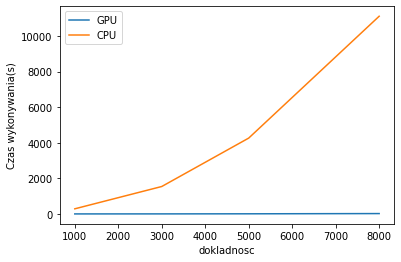

In [14]:
import matplotlib.pyplot as plt
czasgpu = [1.280768,2.931680,7.887904,20.545504]
czascpu = [288.089000,1542.343000,4264.234000,11113.377000]

dokladnosc = [ 1000 ,3000 , 5000 , 8000]

plt.plot(dokladnosc,czasgpu, label="GPU")
plt.plot(dokladnosc,czascpu, label="CPU")
plt.xlabel("dokladnosc")
plt.ylabel("Czas wykonywania(s)")
plt.legend()
plt.show()